### Imports and data loading

In [1]:
from constants import *
from data_loading import *
from data_cleaning import *
from utils import *
from embeddings import *
from prediction import *
import matplotlib.pyplot as plt
import itertools

#import warnings
#warnings.filterwarnings("ignore", category=DeprecationWarning)


# load training set as DataFrame
train = load_df(TRAIN_NEG, TRAIN_POS, TWEET, LABEL, LABEL_NEG, LABEL_POS)
test = pd.DataFrame({TWEET: load_txt(TEST_DATA)})
# set patterns to remove, replace, and replace with
to_remove = "<user>"
to_replace = "[^a-zA-Z#]"
replace_value = " "
# clean training set
#train = clean(train, TWEET, CLEAN_TWEET, to_remove, to_replace, replace_value,option)

### Development

In [2]:
train.dropna(inplace=True)
train.reset_index(drop=True,inplace=True)
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 2 columns):
tweet    200000 non-null object
label    200000 non-null int64
dtypes: int64(1), object(1)
memory usage: 3.1+ MB


In [3]:
x = train.tweet
y = train.label

In [4]:
from sklearn.cross_validation import train_test_split
SEED = 2000
x_train, x_validation_and_test, y_train, y_validation_and_test = train_test_split(x, y, test_size=.02, random_state=SEED)
x_validation, x_test, y_validation, y_test = train_test_split(x_validation_and_test, y_validation_and_test, test_size=.5, random_state=SEED)

C:\Users\LMG\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer
tvec1 = TfidfVectorizer(max_features=100000,ngram_range=(1, 3))
tvec1.fit(x_train)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=100000, min_df=1,
        ngram_range=(1, 3), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words=None, strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

In [6]:
x_train_tfidf = tvec1.transform(x_train)
x_validation_tfidf = tvec1.transform(x_validation).toarray()

In [7]:
%%time
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression()
clf.fit(x_train_tfidf, y_train)

Wall time: 5.74 s


In [8]:
clf.score(x_validation_tfidf, y_validation)

0.839

In [9]:
clf.score(x_train_tfidf, y_train)

0.8729183673469387

In [10]:
seed = 7
np.random.seed(seed)
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import Flatten
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence

Using TensorFlow backend.


In [11]:
def batch_generator(X_data, y_data, batch_size):
    samples_per_epoch = X_data.shape[0]
    number_of_batches = samples_per_epoch/batch_size
    counter=0
    index = np.arange(np.shape(y_data)[0])
    while 1:
        index_batch = index[batch_size*counter:batch_size*(counter+1)]
        X_batch = X_data[index_batch,:].toarray()
        y_batch = y_data[y_data.index[index_batch]]
        counter += 1
        yield X_batch,y_batch
        if (counter > number_of_batches):
            counter=0

In [12]:
from sklearn.preprocessing import Normalizer
norm = Normalizer().fit(x_train_tfidf)
x_train_tfidf_norm = norm.transform(x_train_tfidf)
x_validation_tfidf_norm = norm.transform(x_validation_tfidf)

In [13]:
%%time
model_n = Sequential()
model_n.add(Dense(64, activation='relu', input_dim=100000))
model_n.add(Dense(1, activation='sigmoid'))
model_n.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model_n.fit_generator(generator=batch_generator(x_train_tfidf_norm, y_train, 32),
                    epochs=5, validation_data=(x_validation_tfidf_norm, y_validation),
                    steps_per_epoch=x_train_tfidf_norm.shape[0]/32)

Epoch 1/5
6125/6125 [==============================] - 308s 50ms/step - loss: 0.3972 - acc: 0.8147 - val_loss: 0.3381 - val_acc: 0.8435
Epoch 2/5
6125/6125 [==============================] - 216s 35ms/step - loss: nan - acc: nan - val_loss: 0.3554 - val_acc: 0.8450
Epoch 3/5
6125/6125 [==============================] - 213s 35ms/step - loss: nan - acc: nan - val_loss: 0.4191 - val_acc: 0.8355
Epoch 4/5
6125/6125 [==============================] - 214s 35ms/step - loss: nan - acc: nan - val_loss: 0.5212 - val_acc: 0.8245
Epoch 5/5
6125/6125 [==============================] - 212s 35ms/step - loss: nan - acc: nan - val_loss: 0.6549 - val_acc: 0.8220
Wall time: 19min 23s


In [28]:
x_test_tfidf = tvec1.transform(test)
prediction = model_n.predict(x_test_tfidf)

In [29]:
pd.DataFrame(x_test_tfidf.todense()).transpose().shape

(100000, 1)

In [30]:
preds = clf.predict(x_test_tfidf)
preds

array([1], dtype=int64)

### General functions for this notebook

In [2]:
def generate_all_clean_options():
    all_clean_options = list()
    
    nb_options = 4
    bin_combinations = list(itertools.product([0,1], repeat=nb_options))
    
    for combination in bin_combinations:
        all_clean_options.append({
            'duplicates': combination[0],
            'replace_pattern': combination[1],
            'stop_words': combination[2],
            'stemming': combination[3]
        })

    return all_clean_options
    
def accuracies(classifiers, train, min_df, min_features, max_features, feature_step, ngram_range):
    """ Iterates on the given parameters range and using the specified classifier, logs accuracies obtained into a
    Dataframe"""
    
    df = pd.DataFrame(columns=['method','n-gram', 'replace_pattern','stop_words','stemming','nb_features','accuracy'])
    
    all_clean_options = generate_all_clean_options()
    features_range = np.arange(min_features, max_features, step=feature_step)
    
    nb_steps = len(all_clean_options) * len(ngram_range) * len(features_range) * len(classifiers)
    step = 0
    
    for clean_options in all_clean_options:
        log_msg = '\033[1m{p:.2f}%\033[0m ({step}/{nb_step}), cleaning data with {clean_options}...'.format(
            clean_options= clean_options,
            p = 100 * (step / nb_steps),
            step = step + 1,
            nb_step = nb_steps
        )
        printOver(log_msg)
    
        train_new = clean(train, TWEET, CLEAN_TWEET, to_remove, to_replace, replace_value,clean_options)

        for classifier_str in classifiers:
            if classifier_str is "tfidf":
                classifier = classify_tfidf
            elif classifier_str is "bow":
                classifier = classify_bow
            else:
                raise Exception("Unsupported classify method: "+classifier_str)
                
            for ngram in ngram_range: 
                for nb_features in features_range:
                    log_msg = '\033[1m{p:.2f}%\033[0m ({step}/{nb_step}), classifying with {classifier}, {clean_options}...'.format(
                        classifier = classifier_str,
                        clean_options= clean_options,
                        p = 100 * (step / nb_steps),
                        step = step + 1,
                        nb_step = nb_steps
                    )
                    printOver(log_msg)

                    accuracy = classifier(train_new, None, tweets_col = CLEAN_TWEET, ngram_range=ngram, max_features =nb_features, min_df=min_df)
                    df = df.append({
                        'method': classifier_str, 
                        'n-gram': ngram[1], 
                        'duplicates': clean_options['duplicates'],
                        'replace_pattern': clean_options['replace_pattern'],
                        'stop_words': clean_options['stop_words'],
                        'stemming': clean_options['stemming'],
                        'nb_features': nb_features,
                        'accuracy': accuracy
                    }, ignore_index=True)
                    step = step + 1
                    
    log_msg = '\033[1mDone!\033[0m ({step}/{nb_step})'.format(
            p = 100 * (step / nb_steps),
            step = step,
            nb_step = nb_steps
    )
    printOver(log_msg)
    print("\n")
        
    return df

### Compute all accuracies

In [3]:
df = accuracies(
    ["bow", "tfidf"],
    train = train,
    min_df=1, 
    min_features=10000, 
    max_features=110000,
    feature_step=10000, 
    ngram_range=[(1,1), (1,2), (1,3)]
)

Done! (960/960)), classifying with tfidf, {'duplicates': 1, 'replace_pattern': 1, 'stop_words': 1, 'stemming': 1}...



In [4]:
df

,method,n-gram,replace_pattern,stop_words,stemming,nb_features,accuracy,duplicates
0,bow,1,0,0,0,10000,0.788283,0.0
1,bow,1,0,0,0,20000,0.790850,0.0
2,bow,1,0,0,0,30000,0.792050,0.0
3,bow,1,0,0,0,40000,0.791800,0.0
4,bow,1,0,0,0,50000,0.791767,0.0
5,bow,1,0,0,0,60000,0.791850,0.0
6,bow,1,0,0,0,70000,0.792017,0.0
7,bow,1,0,0,0,80000,0.792050,0.0
8,bow,1,0,0,0,90000,0.792067,0.0
9,bow,1,0,0,0,100000,0.792100,0.0


### Plotting

In [5]:
def pltdf(df, method, ngram, duplicates, replace_pattern, stop_words, stemming):
    """ Extracts all poitns varying on accuracy and nb_features that match the given settings"""
    return df.loc[ 
                (df['method'] == method) &
                (df['n-gram'] == ngram) &
                (df['duplicates'] == duplicates) &
                (df['replace_pattern'] == replace_pattern) &
                (df['stop_words'] == stop_words) &
                (df['stemming'] == stemming)
             ]

def plot_accuracies(accuracies_dfs, legends, colors, linestyles, title, axis_labels, filename):
    import matplotlib.pyplot as plt

    plt.figure(figsize=(8,6))
    
    for i, df in enumerate(accuracies_dfs):
        plt.plot(df['nb_features'], df['accuracy'],label=legends[i],color=colors[i], linestyle=linestyles[i])
        
    plt.title(title)
    plt.xlabel(axis_labels[0])
    plt.ylabel(axis_labels[1])
    plt.legend()
    
    if not os.path.exists(PLOTS_FOLDER):
        os.makedirs(PLOTS_FOLDER)
    plt.savefig(PLOTS_FOLDER + filename + '.pdf') #pdf is a better choice than png as it is vectorial
    
    plt

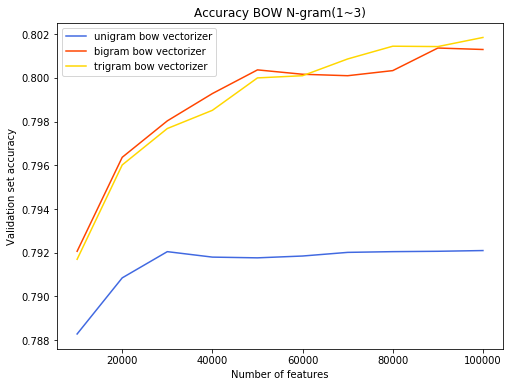

In [6]:
sub_dfs = [
    pltdf(df,"bow", 1, 0, 0, 0, 0),    
    pltdf(df,"bow", 2, 0, 0, 0, 0),
    pltdf(df,"bow", 3, 0, 0, 0, 0),
]

plot_accuracies(
    sub_dfs,
    legends = ['unigram bow vectorizer', 'bigram bow vectorizer', 'trigram bow vectorizer'],
    colors = ['royalblue', 'orangered', 'gold'],
    linestyles = ['-','-','-'],
    title = 'Accuracy BOW N-gram(1~3)',
    axis_labels =['Number of features','Validation set accuracy'],
    filename = "plot_bow"
)

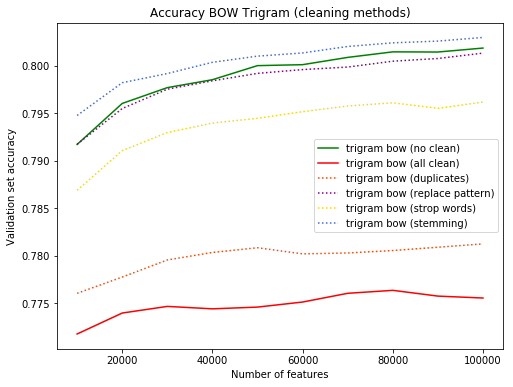

In [18]:
sub_dfs = [
    pltdf(df,"bow", 3, 0, 0, 0, 0),   
    pltdf(df,"bow", 3, 1, 1, 1, 1), 
    pltdf(df,"bow", 3, 1, 0, 0, 0),    
    pltdf(df,"bow", 3, 0, 1, 0, 0),
    pltdf(df,"bow", 3, 0, 0, 1, 0),
    pltdf(df,"bow", 3, 0, 0, 0, 1),
]

plot_accuracies(
    sub_dfs,
    legends = ['trigram bow (no clean)','trigram bow (all clean)', 'trigram bow (duplicates)', 'trigram bow (replace pattern)', 'trigram bow (strop words)', 'trigram bow (stemming)'],
    colors = ['green', 'red', 'orangered', 'purple', 'gold', 'royalblue'],
    linestyles = ['-','-',':',':',':',':'],
    title = 'Accuracy BOW Trigram (cleaning methods)',
    axis_labels =['Number of features','Validation set accuracy'],
    filename = "plot_bow_cleaning"
)

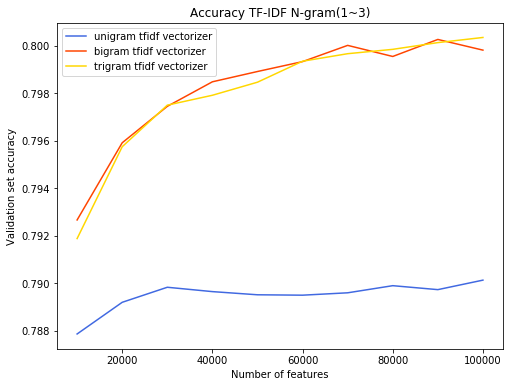

In [7]:
sub_dfs = [
    pltdf(df,"tfidf", 1, 0, 0, 0, 0),    
    pltdf(df,"tfidf", 2, 0, 0, 0, 0),
    pltdf(df,"tfidf", 3, 0, 0, 0, 0),
]

plot_accuracies(
    sub_dfs,
    legends = ['unigram tfidf vectorizer', 'bigram tfidf vectorizer', 'trigram tfidf vectorizer'],
    colors = ['royalblue', 'orangered', 'gold'],
    linestyles = ['-','-','-'],
    title = 'Accuracy TF-IDF N-gram(1~3)',
    axis_labels =['Number of features','Validation set accuracy'],
    filename = "plot_tfidf"
)

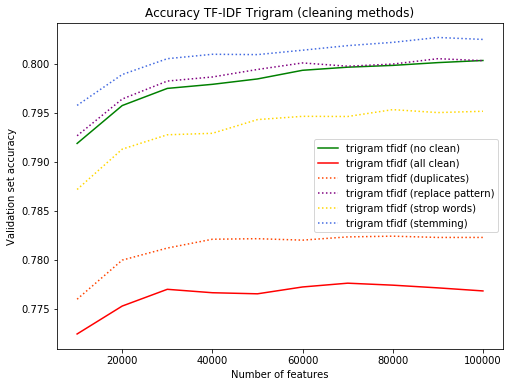

In [17]:
sub_dfs = [
    pltdf(df,"tfidf", 3, 0, 0, 0, 0),   
    pltdf(df,"tfidf", 3, 1, 1, 1, 1), 
    pltdf(df,"tfidf", 3, 1, 0, 0, 0),    
    pltdf(df,"tfidf", 3, 0, 1, 0, 0),
    pltdf(df,"tfidf", 3, 0, 0, 1, 0),
    pltdf(df,"tfidf", 3, 0, 0, 0, 1),
]

plot_accuracies(
    sub_dfs,
    legends = ['trigram tfidf (no clean)','trigram tfidf (all clean)', 'trigram tfidf (duplicates)', 'trigram tfidf (replace pattern)', 'trigram tfidf (strop words)', 'trigram tfidf (stemming)'],
    colors = ['green', 'red', 'orangered', 'purple', 'gold', 'royalblue'],
    linestyles = ['-','-',':',':',':',':'],
    title = 'Accuracy TF-IDF Trigram (cleaning methods)',
    axis_labels =['Number of features','Validation set accuracy'],
    filename = "plot_tfidf_cleaning"
)

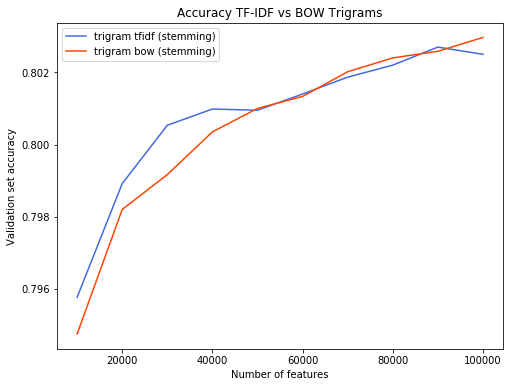

In [20]:
sub_dfs = [
    pltdf(df,"tfidf", 3, 0, 0, 0, 1),    
    pltdf(df,"bow", 3, 0, 0, 0, 1),
]

plot_accuracies(
    sub_dfs,
    legends = ['trigram tfidf (stemming)', 'trigram bow (stemming)'],
    colors = ['royalblue', 'orangered'],
    linestyles = ['-','-'],
    title = 'Accuracy TF-IDF vs BOW Trigrams',
    axis_labels =['Number of features','Validation set accuracy'],
    filename = "plot_tfidf_bow"
)